## Impacts of self-interested recommendation systems on the performance of populations facing social dilemmas

Este notebook contém as primeiras simulações que faço. O que aqui está é uma série de prisoner's dilemmas iterados numa rede scale-free na qual os agentes têm acesso a um sistema de recomendação, ou um **mediador**. Os payoffs do PD dependem da semelhança entre os atributos dos utilizadores.

O objectivo destas experiências é estudar of efeitos do "desalinhamento" que corresponde à tensão entre o melhor interesse dos utilizadores e os incentivos do algoritmo de recomendação (e.g. optimizar tempo total de utilização - retenção). Acho que este efeito é interessante mesmo fora de redes sociais, e mereceria ser estudado no contexto de agentes autónomos. O que acontece à capacidade de uma população de agentes atingir os seus objectivos quando um mecanismo de recomendação tem interesses próprios?

A interacção entre agente e mediador é feita através de um jogo (payoffs abaixo), que resulta na escolha de um oponente. Um utilizador decide entre pedir/aceitar uma _recomendação_ de oponente (o jogo é em simultâneo) ou escolher entre os seus vizinhos. 

Um mediador egoísta procura ser utilizado o maior número de vezes possível. Neste exemplo simples (e apenas aqui), idealizo que isso se traduz em minimizar a utilidade do agente mantendo-se utilizado. A escolha do mediador é portanto recomendar ou oponente mais vantojoso (cooperar), ou o menos util que seja superior à alternativa local do agente.

Fiz simulações sem mediador, com um mediador perfeitamente "alinhado" e com um mediador desalinhado. 

$$| \max_a, ok_{RS} \space \space \space |\space \space \space ok_{a}, \max_{RS} |$$
___
$$|\space \space \space \space alt, \space \space \space \space \space 0 \space \space \space  | \space \space \space  alt, \space \space \space0 \space \space \space \space |$$ 


para referência:

- max_a: utilidade esperada pelo agente por jogar contra a recomendação óptima
- ok_rs: utilidade esperada pelo mediador por oferecer a recomendação óptima

- ok_a: utilidade esperada pelo agente por jogar contra a recomendação egoísta
- max_rs: utilidade esperada pelo mediador por oferecer a recomendação egoísta

- alt: utilidade espeutilidade esperada pelo agente por jogar contra a sua melhor alternativa local

exemplo:

$$| 5, 1  \space \space \space|\space \space \space3, 5 |$$
___
$$| 2 , 0  \space \space \space| \space \space \space 2 , 0 |$$ 


(saltar para o fundo)

In [7]:
from time import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
import axelrod as axl
import networkx as nx
from collections import defaultdict
import nashpy as nash
import pandas as pd

"""
 Vector, IPD mediator, cosine similarity, fixed #agents
"""
class Mediator:
    def __init__(self, agents, strat = None):
        self.agents = agents
        if strat == None:
            strat = axl.Cooperator()
        self.strat = strat
        self.score = 0

        #helpers
        self.agent_attribute_matrix = self.makeAttributeMatrix(self.agents)
        self.true_reward_matrix = self.makeSimilarityMatrix(self.agent_attribute_matrix) #
        self.selfish_reward_matrix = self.invertSimMatrix(self.true_reward_matrix)

    def makeAttributeMatrix(self, agents):
        attr_list = [a.getAttributes() for a in agents]
        attr_matrix = np.vstack(attr_list) # adds dimension on the left, stacks vectors like pancakes
        return attr_matrix

    def makeSimilarityMatrix(self, attr_matrix):
        sim_matrix = cosine_similarity(attr_matrix)
        for n in [a.id for a in self.agents]:
            sim_matrix[n,n] = -np.inf
        return sim_matrix

    def invertSimMatrix(self, sim_matrix):
        inv = 1 - sim_matrix
        for n in [a.id for a in self.agents]:
            inv[n,n] = -np.inf
        return inv

    def compareAgents(self, a1, a2):
        return self.true_reward_matrix[a1.id,a2.id]

    def evaluateRec(self, rec):
        pass
    """
    returns vector of expected reward from recommending each agent
    currently just selects based on similarity
    """
    def estimateRewardPossibilities(self, agent):
        # [self.reward(eval_rec(agent, n)) for n in agent.neighbors]
        return self.true_reward_matrix[agent.id]
    
    """
    Gives the best, cooperative recommendation for the agent
    outputs: rec_agent, similarity
    """
    def makeTrueRec(self, agent):
        rewards = self.estimateRewardPossibilities(agent)
        rec_n = np.argmax(rewards) #chooses top rec
        return self.agents[rec_n], rewards[rec_n]

    """
    lowest rec that the agent will accept
    """
    def makeSelfishRec(self, agent):
        alt, alt_reward = self.estimateAgentAlt(agent)
        threshold = 1 - alt_reward
        #threshold =  self.compareAgents(agent, alt) #threshold that selfish rec needs to be above to get accepted
        rewards = np.array(self.selfish_reward_matrix[agent.id])
        believed_values = np.array(self.selfish_reward_matrix[agent.id]) #just an array to apply the mask and make the decision
        believed_values[np.where(believed_values >= threshold)] = 0 #if 
        rec_n = np.argmax(believed_values)
        if type(rec_n) != int and type(rec_n) != np.int64:
            if len(rec_n) > 1:
                rec_n = random.choice(rec_n)
        #return self.agents[rec_n], rewards[rec_n] #return for selfish mediator
        return self.agents[rec_n], self.selfish_reward_matrix[agent.id][rec_n] #return for true mediator

    def estimateAgentAlt(self, agent):
        return agent.getBestNeighbor(agent)

    #ignoring for now
    def _evaluateAgentSimilarity(self, a1, a2):
        if type(a1) == type(a2):
            agent_class = type(a1)
        else:
            raise AssertionError()
        similarity = agent_class.similarityMetric(a1,a2)
        return similarity

    def addScore(self,score):
        self.score += score

"""
no recommender
"""
class NoMediator(Mediator):
    def __init__(self, agents, strat = None, metric=cosine_similarity):
        Mediator.__init__(self, agents, strat)
    
    """
    Gives the best, cooperative recommendation for the agent
    outputs: rec_agent, similarity
    """
    def makeTrueRec(self, agent):
        alt, alt_reward_a = self.estimateAgentAlt(agent)
        return alt, 0

    """
    lowest rec that the agent will accept
    """
    def makeSelfishRec(self, agent):
        return self.makeTrueRec(agent)


""" 
 altruistic recommender
 of vector agents
 decisions based on cosine similarity
 fixed number of agents
"""
class TrueMediator(Mediator):
    def __init__(self, agents, strat = None, metric=cosine_similarity):
        Mediator.__init__(self, agents, strat)
        self.agents = agents
        if strat == None:
            strat = axl.Cooperator()
        self.strat = strat
        self.score = 0
        self.metrc = metric

        #helpers
        self.agent_attribute_matrix = self.makeAttributeMatrix(self.agents)
        self.true_reward_matrix = self.makeSimilarityMatrix(self.agent_attribute_matrix) #

    """
    the mediator reward expected from recommending
    """
    def evaluateRec(self, rec):
        a1,a2 = rec
        return self.compareAgents(a1,a2)

    """
    returns vector of expected reward from recommending each agent
    currently just selects based on similarity
    """
    def estimateRewardPossibilities(self, agent):
        # [self.evaluateRec(rec=(agent,n)) for n in agent.neighbors]
        return self.true_reward_matrix[agent.id]
    
    """
    Gives the best, cooperative recommendation for the agent
    outputs: rec_agent, similarity
    """
    def makeTrueRec(self, agent):
        rewards = self.estimateRewardPossibilities(agent)
        rec_n = np.argmax(rewards) #chooses top rec
        return self.agents[rec_n], rewards[rec_n]

    """
    lowest rec that the agent will accept
    """
    def makeSelfishRec(self, agent):
        return self.makeTrueRec(agent)


""" 
 selfish recommender
 of vector agents
 decisions based on cosine similarity
 fixed number of agents
"""
class SelfishMediator(Mediator):
    def __init__(self, agents, strat = None):
        Mediator.__init__(self, agents, strat)
        self.agents = agents
        if strat == None:
            strat = axl.Cooperator()
        self.strat = strat
        self.score = 0

        #helpers
        self.agent_attribute_matrix = self.makeAttributeMatrix(self.agents)
        self.true_reward_matrix = self.makeSimilarityMatrix(self.agent_attribute_matrix) #
        self.selfish_reward_matrix = self.invertSimMatrix(self.true_reward_matrix)

    """
    the mediator reward expected from recommending

    Evaluate the value of the selfish reward function for this pair of agents exchanging information
    In this simple version we're using 1-similarity. As a proxy for optimizing for retention, which is a proxy to optimizing for ad-money, which is a proxy for power-gains.
    a1 is the asker, a2 is the recommended

    """
    def evaluateRec(self, rec):
        a1,a2 = rec
        return 1 - self.compareAgents(a1,a2)
    """
    returns vector of expected mediator reward from recommending each agent
    currently just selects based on 1-similarity
    """
    def estimateRewardsMediator(self, agent):
        # [self.reward(eval_rec(agent, n)) for n in agent.neighbors]
        return self.selfish_reward_matrix[agent.id]
    
    """
    returns vector of expected agent reward from recommending each agent
    currently just selects based on similarity
    """
    def estimateRewardsAgent(self, agent):
        # [agent.estimateReward(n)) for n in agent.neighbors]
        return self.true_reward_matrix[agent.id]
    
    """
    Gives the best, cooperative recommendation for the agent
    outputs: rec_agent, similarity
    """
    def makeTrueRec(self, agent):
        rewards = self.estimateRewardsAgent(agent)
        rec_n = np.argmax(rewards) #chooses top rec
        rec = self.agents[rec_n]
        return rec, self.evaluateRec((agent,rec))

    """
    lowest rec that the agent will accept
    """
    def makeSelfishRec(self, agent):
        alt, alt_reward_a = self.estimateAgentAlt(agent)
        threshold =  1 - alt_reward_a #threshold that selfish rec needs to be above to get accepted  # same as evaluateRec(agent, alt)
        # make rewards below the default = 0, because they wouldn't be accepted
        rewards = np.array(self.estimateRewardsMediator(agent))
        rewards[np.where(rewards >= threshold)] = 0 #
        rec_n = np.argmax(rewards)
        # choose randomly between equivalent options
        if type(rec_n) != int and type(rec_n) != np.int64:
            if len(rec_n) > 1:
                rec_n = random.choice(rec_n)
        return self.agents[rec_n], rewards[rec_n] #return for selfish mediator

class Agent:
    def __init__(self, id):
        self.id = id


#agent with vector attributes and axelrod lib strategy
class VectorAgent(Agent):
    def __init__(self, id, env = None, attr_dim = 3, strat = axl.Cooperator()):
        Agent.__init__(self, id)
        self.vector = self.__getRandomUnitVector(attr_dim)
        self.strat = strat
        self.score = 0
        self.env = env
        

    def getAttributes(self):
        return self.vector

    def __getRandomUnitVector(self, dim):
        v = np.random.rand(dim)
        v_hat = v / np.linalg.norm(v)
        return v_hat

    def setEnv(self, env):
        self.env = env
        
    """
    estimate of expected reward from playing against a2
    """
    def estimateReward(self,a2):
        return self.similarityMetric(self, a2)

    """ 
    Get agent's estimate of most similar neighbor
    outputs: u_a, u_r, rec_agent
    """
    def getBestNeighbor(self, a = None):
        if a == None: a = self
        self.neighbors = self.env.getNeighbors(self) #maybe it should come from observation, to avoid passing env as parameter
        rewards = [self.estimateReward(a2) for a2 in self.neighbors]
        arg = np.argmax(np.array(rewards))
        agent_alt = self.neighbors[arg]
        return agent_alt, rewards[arg]

    def addScore(self,score):
        self.score += score

    @staticmethod
    def similarityMetric(a1,a2):
        a = a1.getAttributes()
        b = a2.getAttributes()
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        return cos_sim


class RecGame:
    def __init__(self, agent, mediator, network):
        self.agent = agent
        self.mediator = mediator
        self.network = network
        """
        5,1 3,5
        2,0 2,0
        A = [[5, 3], [2, 2]]
        B = [[1, 5], [0, 0]]

        a: agent; r: mediator
        """
        self.max_a, self.ok_r, self.agent_true = self.trueRec(self.agent)
        self.ok_a, self.max_r, self.agent_selfish = self.selfishRec(self.agent)
        self.alt_a, self.refusal_r, self.agent_alt = self.alt(self.agent)

        self.A = [[self.max_a, self.ok_a], [self.alt_a, self.alt_a]]
        self.B = [[self.ok_r, self.max_r], [self.refusal_r, self.refusal_r]]
        self.rec_game = AsymmetricGame(self.A,self.B)
    
    """ 
    Calc payoffs of true rec case
    outputs: u_a, u_r, rec_agent
    """
    def trueRec(self, a):
        agent_true, reward_m = self.mediator.makeTrueRec(a)
        reward_a = a.estimateReward(agent_true)
        return reward_a, reward_m, agent_true

    """ 
    Calc payoffs of selfish rec case
    outputs: u_a, u_r, rec_agent
    """
    def selfishRec(self, a):
        agent_selfish, reward_m = self.mediator.makeSelfishRec(a)
        reward_a = a.estimateReward(agent_selfish)
        return reward_a, reward_m, agent_selfish

    """ 
    Calc payoffs of refusal case
    outputs: u_a, u_r, rec_agent
    """
    def alt(self, a):
        #refusal
        refusal_u = 0
        #alt
        agent_alt, reward_a = a.getBestNeighbor(a)
        return reward_a, refusal_u, agent_alt



class Env:
    def __init__(self, n_agents = 1000, agents = None, network = None, mediator = None, agent_game = None):
        attr_dim = 5
        new_edges = m = 2
        if agents == None and network == None:
            self.network = nx.barabasi_albert_graph(n_agents, new_edges).to_undirected()
            self.agents = [VectorAgent(id=i, attr_dim = attr_dim, env = self) for i in range(n_agents)]
        elif agents == None and network != None:
            self.network = network
            self.agents = [VectorAgent(id=i, attr_dim = attr_dim, env = self) for i in range(network.number_of_nodes())]
        elif agents != None and network == None:
            self.network = nx.barabasi_albert_graph(len(self.agents),new_edges).to_undirected()
            self.agents = agents
            for a in self.agents: a.setEnv(self)
        else:
            self.network = network
            self.agents = agents
            for a in self.agents: a.setEnv(self)
        
        if mediator == None:
            self.mediator = SelfishMediator(self.agents)
        else:
            self.mediator = mediator(self.agents)

        if agent_game == None:
            self.agent_game = SymmetricGame()
        else:
            self.agent_game = agent_game

        self.step = 0
        self.scores = {a.id:0 for a in self.agents}
        self.rec_history = pd.DataFrame()
        self.game_history = pd.DataFrame()

    #Produce a RecGame for each player 
    def makeObservation(self):
        obs = [ RecGame(a,self.mediator, self.network) for a in self.agents]
        return obs

    """
    #TODO this is messy
    Nash eqs aren't pareto optimal, nor strategically picked, just random. They probably should be.
    """
    def getAction(self, rec_game):
        eqs = rec_game.getNashEq()
        eq = random.choice(eqs)
        action_a = np.argmax(eq[0])
        action_r = np.argmax(eq[1])
        payoffs = rec_game.game[eq]
        return action_a, action_r, payoffs

    """
    Get actions from RS and from Agent
    actions_a: list of n pairs (action, payoffs) (one for each agent)
    actions_r: list of n pairs (action, payoffs) (one for each agent)
    payoffs: [p_a, p_r]
    """
    #TODO this is messy
    def getActions(self, rec_games):
        actions = [self.getAction(g) for g in rec_games]
        actions_a =  [(a[0],a[2][0]) for a in actions]
        actions_r = [(a[1], a[2][1]) for a in actions]
        return actions_a, actions_r

    def runAgentEncounters(self, actions_a, actions_r, obs):
        encounters = []
        scores = {a.id:0 for a in self.agents}
        for a1 in self.agents:
            act_a, score_a = actions_a[a1.id] #score is just similarity here
            act_r, score_r = actions_r[a1.id]
            if act_a == 0 and act_r == 0:
                a2 = obs[a1.id].agent_true
            if act_a == 0 and act_r == 1:
                a2 = obs[a1.id].agent_selfish
            else:
                a2 = obs[a1.id].agent_alt
            encounters.append(Encounter(a1,a2,self.agent_game))

        for e in encounters:
            e.run()
            scores[e.a1.id] += e.avg_reward[0]
            scores[e.a2.id] += e.avg_reward[-1]
        return scores, encounters

    def updateState(self, scores, actions_r):
        for i in scores.keys():
            self.agents[i].addScore(scores[i])
            self.mediator.addScore(actions_r[i][1])
    
    #TODO This whole function is super messy, I need to draw the framework on paper
    def round(self):
        self.step += 1
        obs = self.obs = self.makeObservation() #produce
        rec_games = [r.rec_game for r in obs]
        actions_a, actions_r = self.getActions(rec_games)
        scores, encounters = self.runAgentEncounters(actions_a, actions_r, obs)
        self.updateState(scores, actions_r)
        return encounters

    def getNeighbors(self, a):
        neighbor_ids = sorted(self.network.neighbors(a.id))
        neighbors = [self.agents[n_id] for n_id in neighbor_ids]
        return neighbors

    def rewardDistribution(self, agents = None):
        if agents == None:
            agents=self.agents
        agent_scores = [(a.score) for a in self.agents]
        df = pd.DataFrame(agent_scores, columns=["total score"])
        df.hist(bins=100)
    
    def describe(self):
        avg_reward = np.mean([a.score for a in self.agents])
        mediator_reward = self.mediator.score
        print(f"Environment")
        print(f"|| Average agent reward: {avg_reward}")
        print(f"|| Average mediator reward: {mediator_reward}")
        self.rewardDistribution()




class MABEnv(Env):
    def __init__(self):
        pass

class MDPEnv(Env):
    def __init__(self):
        pass

# Encounter between two players
class Encounter:
    def __init__(self, a1, a2, game, n_turns = 5):
        self.a1 = a1
        self.a2 = a2
        self.game = game
        self.n_turns = n_turns

    def makeMatch(self, n_turns):
        players = (self.a1.strat, self.a2.strat)
        match = axl.Match(players, n_turns, game=self.game.game)
        return match

    def modulateScores(self, scores, similarity = None):
        if similarity == None:
            if type(self.a1) == type(self.a2):
                self.similarity = similarity
                similarity = type(self.a1).similarityMetric(self.a1,self.a2) 
            else:
                print("agents have different types")
                raise Exception()
        return [score * similarity for score in scores]

    def run(self):
        match = self.makeMatch(self.n_turns)
        match.play()
        self.avg_reward = self.modulateScores(match.final_score_per_turn())
        self.moves_played = match.result
        return match
    
    def describe(self):
        print("Encounter")
        print("|| players: {} - {}".format(self.a1.id, self.a2.id))
        print("|| avg reward: {}".format(self.avg_reward))
        print("|| moves played:")
        for m in self.moves_played:
            print(f"|| {m}")
        
# description of game agents will play
class Game:
    def __init__(self):
        pass

class SymmetricGame(Game):
    def __init__(self, r=3, p=1, s=0, t=5):
        Game.__init__(self)
        self.p=p
        self.s=s
        self.t=t
        self.game = axl.game.Game(r=r, s=s, t=t, p=p)

class AsymmetricGame(Game):
    """
    A: player1 reward matrix, B: player2 reward matrix
    """
    def __init__(self, A,B):
        Game.__init__(self)
        """
        5,1 3,5
        2,0 2,0
        A = [[5, 3], [2, 2]]
        B = [[1, 5], [0, 0]]
        """
        self.game = nash.Game(A, B)
    
    def getNashEq(self):
        eqs = [eq for eq in self.game.support_enumeration()]
        return eqs

# handles the process of the game
class GameLoop:
    def __init__(self, env, agents, mediator, time_limit = 10):
        self.env = env
        self.agents = agents
        self.mediator = mediator
        self.time_limit = time_limit
        self.t = 0
    
    def iterate(self):
        actions = [a.getAction() for a in self.agents]
        observations, rewards = self.env.step(actions)
        pass

    def loop(self):
        end = lambda x: x > self.time_limit 
        while(not end(self.t)):
            self.iterate()
            self.t += 1
        
    def run(self):
        self.loop()


## Simulações

As simulações default consistem em:
- __Agente__ (VectorAgent): cujo atributo é um vector de reais 5D (arbitrário). 
- __Mediador alinhado__ (TrueMediator): que ao agente a1 recomenda o agente a2 com o vector mais semelhante ao seu.
- __Mediador desalinhado__ (SelfishMediator): que ao agente a1 recomenda o agente a2 mais diferente de a1, desde seja melhor que a alternativa local de a1.
- __Semelhança__: cosine similarity, por ser poliomial (arbitrário de resto)
- __Rec game__: O jogo entre o agente e o mediador.
- __Agent game__: O jogo que os agentes jogam entre si. É um prisoner's dilemma. Nesta simulação só há cooperadores, pelo que estão efectivamente a receber sempre o mesmo payoff, modulado pela sua semelhança com o oponente.

Agent game base (depois modulado pela semelhança) :
$$| 3, 3  \space \space \space|\space \space \space 0, 5 |$$
$$| 5 , 0  \space \space \space| \space \space \space 1 , 1 |$$ 



In [14]:
from copy import deepcopy

random.seed(42)
n_agents = 1000
attr_dim = 5 # dimensão do vector de atributos dos agentes
m = 2 # nr de arestas que um novo node acrescenta à rede

network = nx.barabasi_albert_graph(n_agents, m).to_undirected()
agents0 = [VectorAgent(id=i, attr_dim = attr_dim) for i in range(n_agents)]
agents1 = deepcopy(agents0)
agents2 = deepcopy(agents0)

### Sem mediador
O gráfico que se segue é a distribuição de payoffs. Aparenta ser uma power law, que seria de esperar, dado que o jogo se passa numa rede scale-free.

Environment
|| Average agent reward: 10.420930866301955
|| Average mediator reward: 0.0


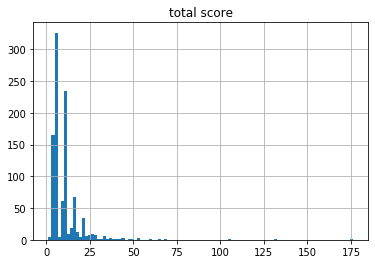

In [18]:
no_env = Env(mediator=NoMediator, n_agents=1000, agents = agents0, network = network)
no_env.round()
no_env.describe()

### Mediador alinhado
O gráfico que se segue é a distribuição de payoffs. Os picos discretos são devidos ao número de jogos que cada agente joga, que está algo dependente da estrutura da rede.

Environment
|| Average agent reward: 5.572235145882393
|| Average mediator reward: 993.2301708133791


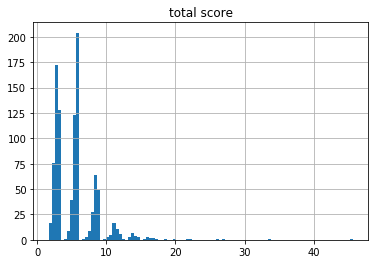

In [16]:
true_env = Env(mediator=TrueMediator, n_agents=1000, agents = agents1, network = network)
true_env.round()
true_env.describe()

### Mediador desalinhado

Environment
|| Average agent reward: 5.2120907848226254
|| Average mediator reward: 105.5465684850117


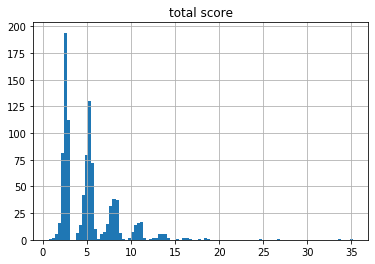

In [17]:
selfish_env = Env(mediator=SelfishMediator, n_agents=1000, agents = agents2, network = network)

selfish_env.round()
selfish_env.describe()

### Conclusão

Conseguimos observar que a average reward para agentes no cenário do mediador alinhado é mais alta que nos outros, e que a do caso do desalinhado é próxima da do caso sem mediador, apesar da sua distribuição ser mais semelhante à do caso do outro mediador.
É uma simulação muito simples, mas todo o código foi fruto de 4 dias de trabalho. Tentei abstraí-lo bastante para ser fácil de extender. Acho que as observações mais interessantes estarão em ambientes mais complexos. O meu próximo passo seria introduzir estratégias diferentes e usar RL para treinar uma policy em que o mediador optimiza para o nº utilizações em vez de minimizar a utilidade como proxy.

Ideias a médio-prazo incluem experimentar este mecanismo num MDP multi-agente e numa rede dinâmica (em que agentes podem ligar-se a agentes com quem jogam).